Dogs vs. Cats
-------------
本项目根据[Kaggle](https://www.kaggle.com/c/dogs-vs-cats/)上的一个比赛改编。具体改动处为删除了未标注的测试集而把原来的训练集分为三部分(训练集、验证集
和测试集)，这样测试集就是有标注的了，可以用来衡量模型的性能。

### 1. Split dataset

In **dataset** folder, there are 25000 images, 12500 for cats and 12500 for dogs. We will devide these images into 3 groups, train dataset(18000 images), validation dataset(2000 images) and test dataset(5000 images). The structure in **dataset** folder should be as followed:
```txt
|-- Dogs vs. Cats
    |-- code.ipynb
    |-- dataset
        |-- train
            |-- dog.0.jpg
            |-- ...
            |-- dog.8999.jpg
            |-- cat.0.jpg
            |-- ...
            |-- cat.8999.jpg
        |-- validation
            |-- dog.9000.jpg
            |-- ...
            |-- dog.9999.jpg
            |-- cat.9000.jpg
            |-- ...
            |-- cat.9999.jpg
        |-- test
            |-- dog.10000.jpg
            |-- ...
            |-- dog.12499.jpg
            |-- cat.10000.jpg
            |-- ...
            |-- cat.12499.jpg
```

The manipulation of splitting dataset is in [split_dataset.py](./split_dataset.py)

### 2. Build Model

We try to use a structure which is similar to VGG16 to build CNN. The structure of our model is showed as followed:
![vgg16](./model_data/vgg16.png)
We will manually make some small modification by changing the input size and full connection layers, and reducing some convolutional layers to avoid over fitting.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

# Define some constants about inputs
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

# build our model
model = Sequential(name='cnn')
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1', 
          input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
                       
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))   

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))  

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dropout(0.25, name='dropout_1'))
model.add(Dense(512, activation='relu', name='fc2'))
model.add(Dropout(0.50, name='dropout_2'))
model.add(Dense(2, activation='softmax', name='outputs'))

model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 32)      896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 32)      9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 128)       73856   

In [2]:
from tensorflow.keras import optimizers

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### 3. Load dataset and Preprocess data

In [3]:
import os
import pandas as pd

BASE_DIR = './dataset'
files_train = os.listdir(os.path.join(BASE_DIR, 'train'))
files_validation = os.listdir(os.path.join(BASE_DIR, 'validation'))

# get the dataframe of train dataset
categories = []
for file in files_train:
    if 'dog' in file:
        categories.append('dog')
    else:
        categories.append('cat')
df_train = pd.DataFrame({
    'file': files_train,
    'category': categories
})

# get the dataframe of validation dataset
categories = []
for file in files_validation:
    if 'dog' in file:
        categories.append('dog')
    else:
        categories.append('cat')
df_validation = pd.DataFrame({
    'file': files_validation,
    'category': categories
})

df_train.head(10)

,file,category
0,cat.6802.jpg,cat
1,dog.4407.jpg,dog
2,dog.538.jpg,dog
3,cat.2871.jpg,cat
4,cat.4858.jpg,cat
5,dog.7048.jpg,dog
6,cat.5668.jpg,cat
7,dog.6675.jpg,dog
8,dog.291.jpg,dog
9,dog.3470.jpg,dog


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 100  # 100 examples one batch

# data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_dataframe(df_train, 
                                                    './dataset/train',
                                                    x_col = 'file',
                                                    y_col = 'category',
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = train_datagen.flow_from_dataframe(df_validation, 
                                                    './dataset/validation',
                                                    x_col = 'file',
                                                    y_col = 'category',
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')
print(train_generator.class_indices)
print(validation_generator.class_indices)

Found 18000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}


### 4. Train model

Before training the model, we should set some callbacks.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# set callbacks
earlystopping = EarlyStopping(monitor='val_accuracy',
                              patience=10)
modelcheckpoint = ModelCheckpoint(filepath='./model_data/best_model.h5',
                                  monitor='val_accuracy',
                                  save_best_only=True)
reducelronplateau = ReduceLROnPlateau(monitor='val_loss',
                                      factor=0.5,
                                      patience=2)
callbacks = [earlystopping, modelcheckpoint, reducelronplateau]

# train 
num_train_examples = df_train.shape[0]
num_validation_examples = df_validation.shape[0]
EPOCHS = 500
history = model.fit(train_generator,
                              steps_per_epoch=num_train_examples//BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_data=validation_generator,
                              validation_steps=num_validation_examples//BATCH_SIZE,
                              callbacks=callbacks)
model.save('./model_data/model.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 180 steps, validate for 20 steps
Epoch 1/500
180/180 [==============================] - 150s 832ms/step - loss: 0.7523 - accuracy: 0.5046 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/500
180/180 [==============================] - 147s 815ms/step - loss: 0.6941 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/500
180/180 [==============================] - 147s 817ms/step - loss: 0.7350 - accuracy: 0.5076 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 4/500
180/180 [==============================] - 147s 814ms/step - loss: 0.7009 - accuracy: 0.5243 - val_loss: 0.6909 - val_accuracy: 0.5265
Epoch 5/500
180/180 [==============================] - 147s 814ms/step - loss: 0.7101 - accuracy: 0.5497 - val_loss: 0.6849 - val_accuracy: 0.5540
Epoch 6/500
180/180 [==============================] - 146s 812ms/step - loss: 0.6939 - accuracy: 0.5637 - val_loss: 0.6849 - val_accuracy: 0.5610
Epoch 7/500
180/180 [====

### 5. Plot accuracy and loss curves

Text(0, 0.5, 'Loss')

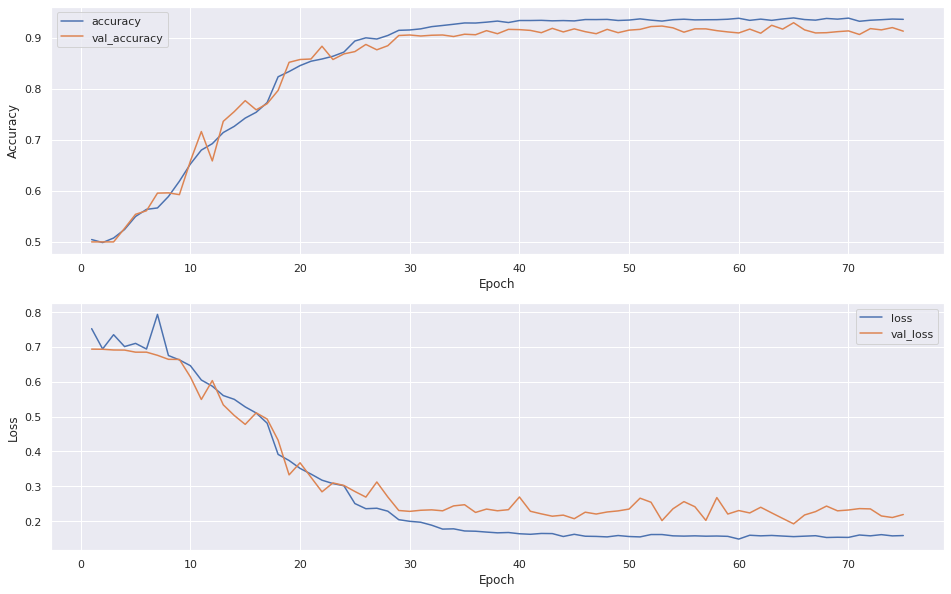

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np

epochs = np.array([i for i in range(1, len(history.history['accuracy'])+1)])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
sns.lineplot(epochs, acc, ax=axes[0], label='accuracy')
sns.lineplot(epochs, val_acc, ax=axes[0], label='val_accuracy')
sns.lineplot(epochs, loss, ax=axes[1], label='loss')
sns.lineplot(epochs, val_loss, ax=axes[1], label='val_loss')
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

### 6. Evaluate model
We will use the test dataset to evaluate the accuracy of our model.

In [8]:
import os
import pandas as pd

TEST_DIR = './dataset/test'
if os.path.exists(os.path.join(TEST_DIR, '.DS_Store')):
    os.remove(os.path.join(TEST_DIR, '.DS_Store'))

# get the dataframe of test dataset
categories = []
files = os.listdir(TEST_DIR)
for file in files:
    if 'dog' in file:
        categories.append(1)
    else:
        categories.append(0)
df_test = pd.DataFrame({
    'file': files,
    'category': categories
})
df_test.head(10)

,file,category
0,dog.11977.jpg,1
1,cat.12433.jpg,0
2,dog.10174.jpg,1
3,dog.10207.jpg,1
4,dog.11445.jpg,1
5,dog.11505.jpg,1
6,cat.11623.jpg,0
7,dog.12380.jpg,1
8,cat.11619.jpg,0
9,cat.11049.jpg,0


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 10

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test, 
    "./dataset/test", 
    x_col='file',
    y_col=None,
    target_size=(150, 150),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5000 validated image filenames.


In [10]:
import numpy as np

num_test_examples = df_test.shape[0]
predictions = model.predict(test_generator, steps=num_test_examples//BATCH_SIZE)
df_test['prediction'] = np.argmax(predictions, axis=-1).reshape(num_test_examples, 1)

In [11]:
correct_answers = 0
for index, row in df_test.iterrows():
    file = row['file']
    prediction = row['prediction']
    category = row['category']
    if category == prediction:
        correct_answers += 1
accuracy = correct_answers / num_test_examples
print("correct answers: {}".format(correct_answers))
print("total examples: {}".format(num_test_examples))
print("accuracy = {0}".format(accuracy))

correct answers: 4647
total examples: 5000
accuracy = 0.9294


Plot some samples of out predictions.

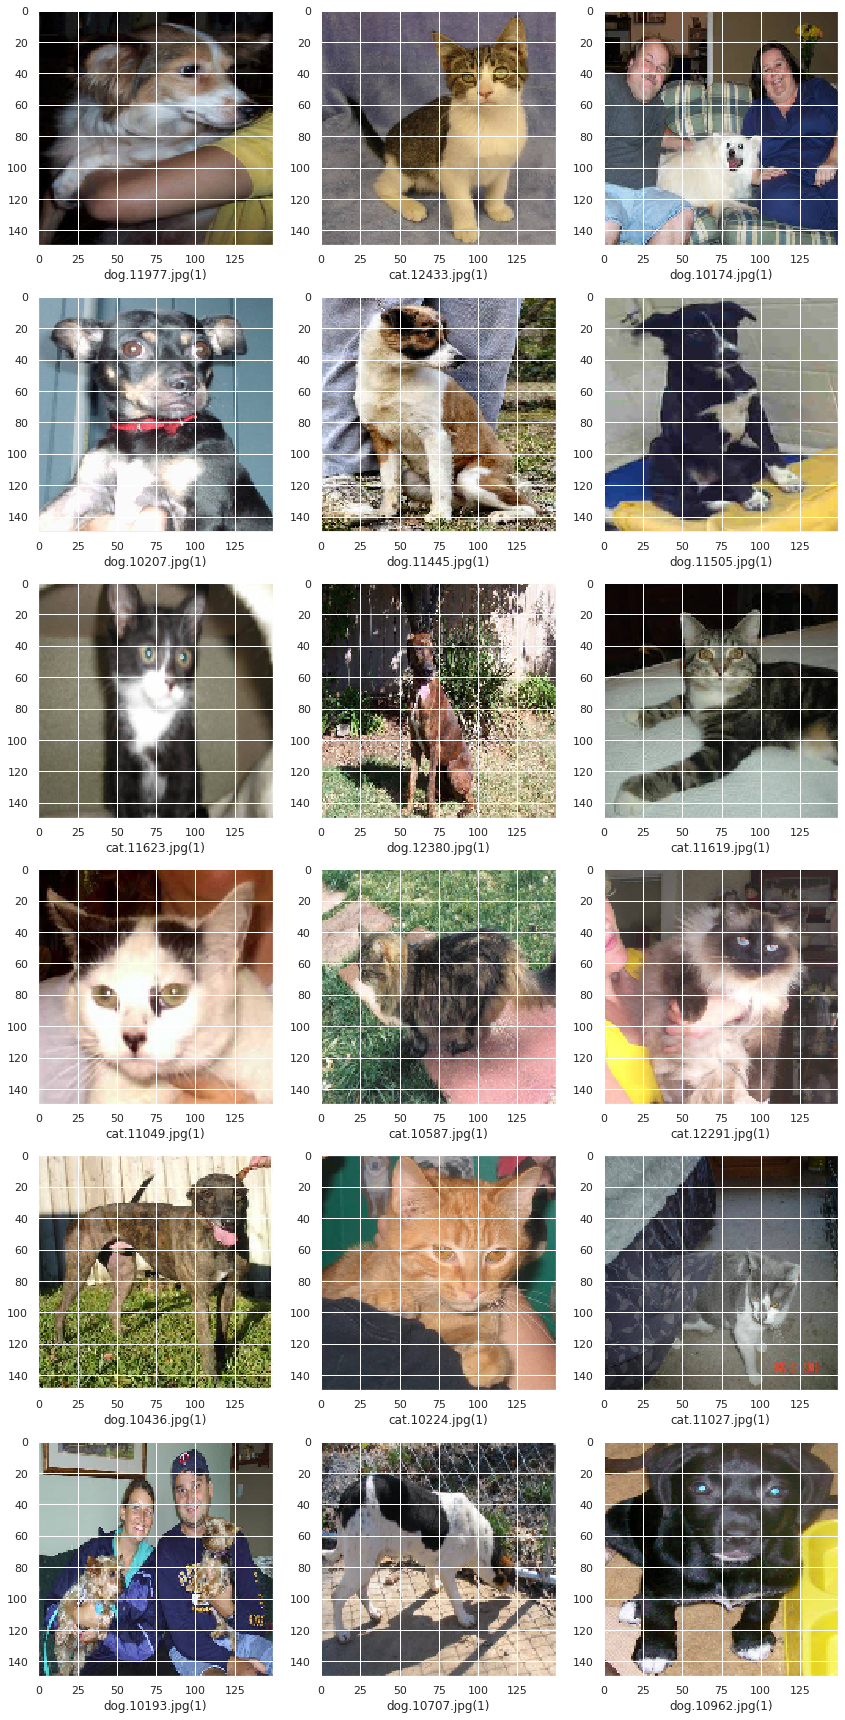

In [12]:
from tensorflow.keras.preprocessing.image import load_img

sample = df_test.head(18)
plt.figure(figsize=(12, 24))
for index, row in sample.iterrows():
    file = row['file']
    category = row['prediction']
    img = load_img("./dataset/test/"+file, target_size=(150, 150))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(file + '(' + "{}".format(prediction) + ')' )
plt.tight_layout()
plt.show()